# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [106]:
!ls -al /input

total 8308
drwxr-xr-x   4 root root    6144 Apr 29 00:27 .
drwxr-xr-x 139 root root    4096 Aug 16 16:16 ..
drwxr-xr-x   2 root root 6137856 Apr 28 19:01 img_align_celeba
drwxr-xr-x   2 root root 2365440 Apr 28 18:57 mnist


In [107]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

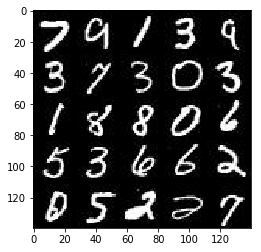

In [108]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

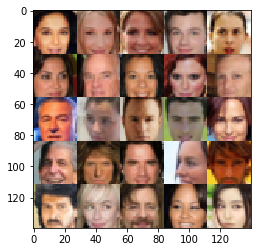

In [109]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [110]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [111]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [112]:
def discriminator(images, reuse=False, alpha=0.1, kernel=5, filters=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    dropout_rate = 0.1
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(
            images, filters, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, dropout_rate, training=True)
        # 14x14x64
        
        x2 = tf.layers.conv2d(
            relu1, filters*2, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, dropout_rate, training=True)
        # 7x7x128
        
        x3 = tf.layers.conv2d(
            relu2, filters*4, kernel, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, dropout_rate, training=True)
        
        flat = tf.reshape(relu3, (-1, 7*7*filters*4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [113]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, kernel=5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(
            x1, 256, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(
            x2, 128, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [114]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    ones_like_real = tf.ones_like(d_model_real)
    one_sided_smooth_labels = tf.multiply(
        ones_like_real,
        tf.random_uniform((1,), minval=0.8, maxval=1.)
    )

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=one_sided_smooth_labels
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [115]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [116]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [117]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                
                
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        25,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2113... Generator Loss: 6.3877 Sum Loss: 6.5990
Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 7.5634 Sum Loss: 7.9041
Epoch 1/2... Discriminator Loss: 0.5223... Generator Loss: 5.1342 Sum Loss: 5.6564
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 0.8152 Sum Loss: 1.7331
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 7.9637 Sum Loss: 8.4532
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 5.5327 Sum Loss: 6.1001
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.1542 Sum Loss: 2.2715
Epoch 1/2... Discriminator Loss: 2.4209... Generator Loss: 12.0854 Sum Loss: 14.5064
Epoch 1/2... Discriminator Loss: 0.3610... Generator Loss: 2.5064 Sum Loss: 2.8674
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 2.0387 Sum Loss: 3.0691


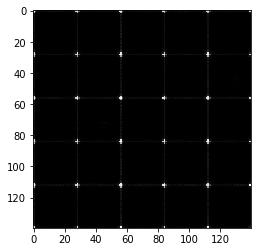

Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.5758 Sum Loss: 2.5135
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.3807 Sum Loss: 2.2740
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 1.0621 Sum Loss: 2.1972
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.1954 Sum Loss: 2.3441
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.9198 Sum Loss: 2.2102
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 1.1212 Sum Loss: 2.3098
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.0822 Sum Loss: 2.2512
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 1.0739 Sum Loss: 2.2793
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.8593 Sum Loss: 2.2419
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.9416 Sum Loss: 2.0371


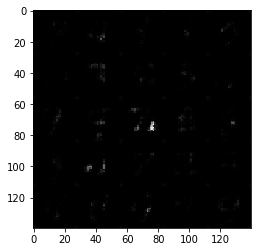

Epoch 1/2... Discriminator Loss: 1.7203... Generator Loss: 0.4328 Sum Loss: 2.1531
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 1.1972 Sum Loss: 2.5053
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.4098 Sum Loss: 2.8170
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 1.3347 Sum Loss: 2.6804
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.4231 Sum Loss: 1.8095
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.9632 Sum Loss: 2.4443
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 1.1916 Sum Loss: 2.4623
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.6059 Sum Loss: 2.0881
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.7207 Sum Loss: 2.0254
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.7568 Sum Loss: 2.1020


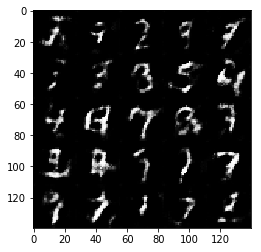

Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.6990 Sum Loss: 2.0499
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.9223 Sum Loss: 2.1871
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.3753 Sum Loss: 2.5956
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.8246 Sum Loss: 2.1606
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.7668 Sum Loss: 1.9738
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.8162 Sum Loss: 2.1586
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 1.4175 Sum Loss: 2.6046
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.9371 Sum Loss: 2.1349
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 1.2044 Sum Loss: 2.4868
Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.4653 Sum Loss: 2.0467


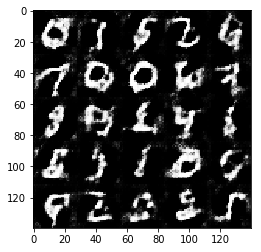

Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 1.1630 Sum Loss: 2.3950
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 1.3670 Sum Loss: 2.7209
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 1.3517 Sum Loss: 2.5885
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 1.2635 Sum Loss: 2.6088
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.8158 Sum Loss: 2.0932
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.6621 Sum Loss: 2.0387
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.9058 Sum Loss: 2.1770
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 1.1566 Sum Loss: 2.3844
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 1.2276 Sum Loss: 2.4914
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.4674 Sum Loss: 2.7555


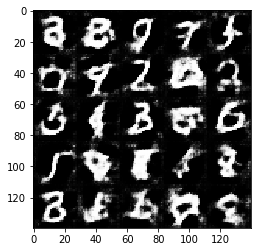

Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.3957 Sum Loss: 2.6103
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.1690 Sum Loss: 2.2677
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.5906 Sum Loss: 1.8768
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.7307 Sum Loss: 1.9644
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.6999 Sum Loss: 2.1082
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.8431 Sum Loss: 2.1009
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.8599 Sum Loss: 2.1159
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.0015 Sum Loss: 2.2173
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 1.3198 Sum Loss: 2.6118
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 1.1594 Sum Loss: 2.2560


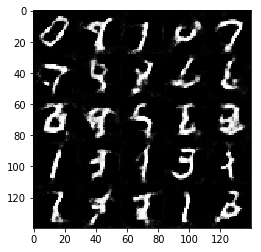

Epoch 1/2... Discriminator Loss: 1.6524... Generator Loss: 0.3956 Sum Loss: 2.0480
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 1.1900 Sum Loss: 2.2924
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.9153 Sum Loss: 1.9751
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8880 Sum Loss: 2.1268
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 0.8927 Sum Loss: 1.9791
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 1.1352 Sum Loss: 2.3905
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 1.4556 Sum Loss: 2.7017
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.4657 Sum Loss: 2.6495
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 1.0274 Sum Loss: 2.2732
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 1.1125 Sum Loss: 2.3653


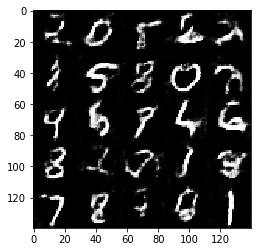

Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.9705 Sum Loss: 2.1572
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.8998 Sum Loss: 2.1045
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.4007 Sum Loss: 2.6808
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 1.8579 Sum Loss: 3.3153
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.7252 Sum Loss: 1.8211
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.9023 Sum Loss: 2.1724
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.9760 Sum Loss: 2.2940
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 1.4286 Sum Loss: 2.6473
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.9697 Sum Loss: 2.2658
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.6337 Sum Loss: 1.9725


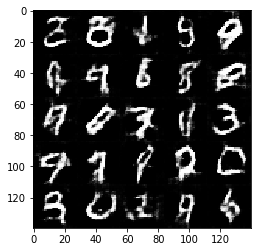

Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.7892 Sum Loss: 2.0018
Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.6592 Sum Loss: 1.9358
Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 1.3110 Sum Loss: 2.5108
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.8543 Sum Loss: 2.1456
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 1.2042 Sum Loss: 2.3203
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 1.3913 Sum Loss: 2.7085
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 1.4905 Sum Loss: 2.8039
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 1.0221 Sum Loss: 2.3447
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.3585 Sum Loss: 2.5240
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 1.4312 Sum Loss: 2.6468


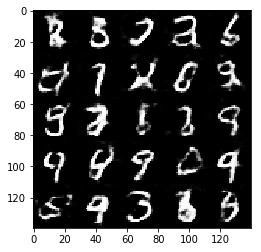

Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 1.4273 Sum Loss: 2.7356
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.8439 Sum Loss: 2.1974
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 1.3301 Sum Loss: 2.6138
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.9406 Sum Loss: 2.1789
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.9356 Sum Loss: 2.1184
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 1.3060 Sum Loss: 2.3499
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 1.8517 Sum Loss: 3.1245
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.1782 Sum Loss: 2.1948
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 1.2866 Sum Loss: 2.3710
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.7252 Sum Loss: 1.9852


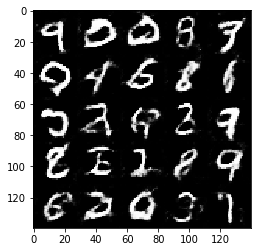

Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 1.1843 Sum Loss: 2.2746
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.7024 Sum Loss: 1.8790
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.9823 Sum Loss: 2.1073
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 1.1261 Sum Loss: 2.2824
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.8141 Sum Loss: 2.0807
Epoch 2/2... Discriminator Loss: 1.1977... Generator Loss: 1.2422 Sum Loss: 2.4399
Epoch 2/2... Discriminator Loss: 1.7650... Generator Loss: 0.4236 Sum Loss: 2.1886
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 1.6707 Sum Loss: 2.8923
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 1.1460 Sum Loss: 2.3429
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.7255 Sum Loss: 1.9844


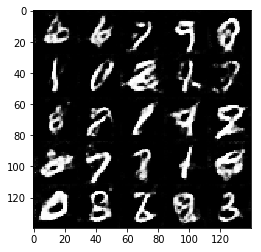

Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6233 Sum Loss: 1.9885
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 1.4539 Sum Loss: 2.6533
Epoch 2/2... Discriminator Loss: 1.5858... Generator Loss: 0.5425 Sum Loss: 2.1284
Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 1.6732 Sum Loss: 3.0221
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.9492 Sum Loss: 2.1571
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 1.1100 Sum Loss: 2.2269
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 1.1006 Sum Loss: 2.3253
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.7185 Sum Loss: 2.0578
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.6428 Sum Loss: 2.0623
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.9378 Sum Loss: 2.0356


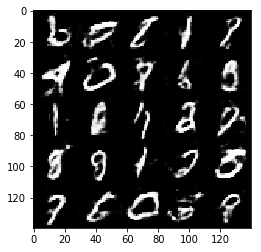

Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 1.0536 Sum Loss: 2.2322
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.9059 Sum Loss: 2.0507
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.5518 Sum Loss: 1.9675
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 1.7958 Sum Loss: 3.0725
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.2231 Sum Loss: 2.3192
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 1.5520 Sum Loss: 2.7095
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.7933 Sum Loss: 1.9130
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 1.2974 Sum Loss: 2.4612
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 1.0336 Sum Loss: 2.1690
Epoch 2/2... Discriminator Loss: 1.2385... Generator Loss: 0.7834 Sum Loss: 2.0218


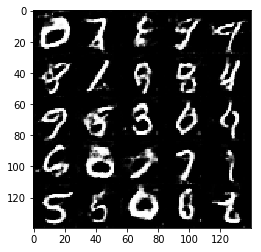

Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 1.3936 Sum Loss: 2.5796
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 0.8966 Sum Loss: 1.8973
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.7621 Sum Loss: 2.1439
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.5216 Sum Loss: 1.8973
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 1.3518 Sum Loss: 2.4537
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 0.9139 Sum Loss: 2.0360
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 0.9477 Sum Loss: 2.0758
Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 2.0686 Sum Loss: 3.5213
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 1.0030 Sum Loss: 2.0935
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.6413 Sum Loss: 1.9076


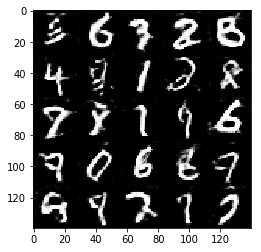

Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 1.1414 Sum Loss: 2.3544
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 1.7366 Sum Loss: 2.9818
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.9385 Sum Loss: 2.0180
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 1.3967 Sum Loss: 2.8098
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 1.5381 Sum Loss: 2.7049
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 1.4423 Sum Loss: 2.5061
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 0.8982 Sum Loss: 1.9868
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.7400 Sum Loss: 1.9141
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.5282 Sum Loss: 1.8950
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.9205 Sum Loss: 2.1253


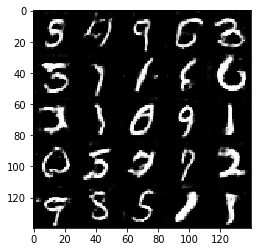

Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 1.0931 Sum Loss: 2.2201
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 1.4563 Sum Loss: 2.7755
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 1.6495 Sum Loss: 2.7944
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.4314 Sum Loss: 1.8795
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.8966 Sum Loss: 2.0796
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.8664 Sum Loss: 2.1575
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 1.5800 Sum Loss: 2.9475
Epoch 2/2... Discriminator Loss: 1.1079... Generator Loss: 0.9141 Sum Loss: 2.0220
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 1.0815 Sum Loss: 2.3368
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.7267 Sum Loss: 2.0583


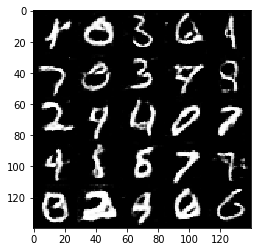

Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 1.4652 Sum Loss: 2.6169
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 0.9805 Sum Loss: 2.0864
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 1.0269 Sum Loss: 2.1105
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.4528 Sum Loss: 1.8832
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.3668 Sum Loss: 2.4598
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.1616 Sum Loss: 2.1590
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.6503 Sum Loss: 2.8351
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.8685 Sum Loss: 2.0818
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.7603 Sum Loss: 1.8635
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.5737 Sum Loss: 2.7342


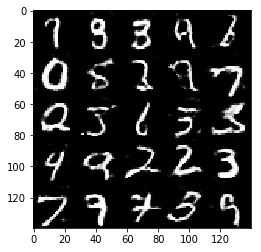

Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.7894 Sum Loss: 1.9723
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.4623 Sum Loss: 2.5171
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.7557 Sum Loss: 2.0290
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 1.1964 Sum Loss: 2.3231
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 1.0489 Sum Loss: 2.1850
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.6353 Sum Loss: 2.0274
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.9621 Sum Loss: 2.1548
Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 1.0596 Sum Loss: 2.2225
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.5880 Sum Loss: 2.7214
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.1011 Sum Loss: 2.2685


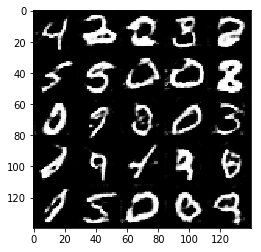

Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.8654 Sum Loss: 2.1056
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.0183 Sum Loss: 2.1204
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.8865 Sum Loss: 2.0160
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 0.8197 Sum Loss: 1.9550
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.8355 Sum Loss: 2.1693
Epoch 2/2... Discriminator Loss: 1.5545... Generator Loss: 0.4698 Sum Loss: 2.0242
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 0.8344 Sum Loss: 2.0044


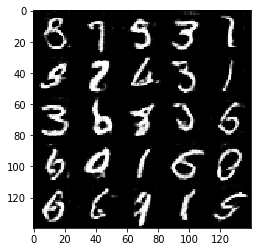

In [118]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.2679 Sum Loss: 2.9274
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 4.4281 Sum Loss: 5.1108
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.8820 Sum Loss: 2.7606
Epoch 1/1... Discriminator Loss: 1.9669... Generator Loss: 0.3517 Sum Loss: 2.3186
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 2.5036 Sum Loss: 3.4906
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.6327 Sum Loss: 2.6701
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.7437 Sum Loss: 2.6029
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.5107 Sum Loss: 3.2208
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 3.2798 Sum Loss: 3.7152
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 4.0637 Sum Loss: 4.6202


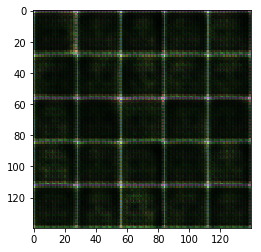

Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.3869 Sum Loss: 2.3845
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 4.8847 Sum Loss: 6.1609
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.0857 Sum Loss: 2.6202
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.9658 Sum Loss: 2.6991
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 4.2386 Sum Loss: 5.1755
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 4.2662 Sum Loss: 5.1360
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.4801 Sum Loss: 2.2695
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.4491 Sum Loss: 2.3304
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 4.4991 Sum Loss: 5.1810
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 2.2499 Sum Loss: 2.7938


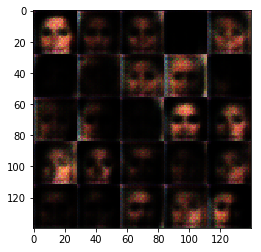

Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 2.8134 Sum Loss: 3.2593
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 4.4956 Sum Loss: 5.1432
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.2878 Sum Loss: 2.2985
Epoch 1/1... Discriminator Loss: 1.9876... Generator Loss: 0.3881 Sum Loss: 2.3758
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7735 Sum Loss: 2.1488
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.4207 Sum Loss: 2.9493
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 2.4549 Sum Loss: 3.0334
Epoch 1/1... Discriminator Loss: 2.3586... Generator Loss: 0.2182 Sum Loss: 2.5767
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.1255 Sum Loss: 2.2496
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 4.2920 Sum Loss: 5.4639


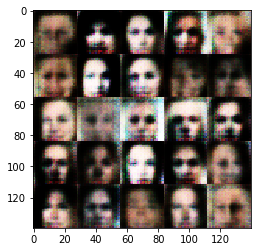

Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9493 Sum Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.6435 Sum Loss: 3.2224
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 3.1778 Sum Loss: 4.3162
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 5.0041 Sum Loss: 5.8459
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 5.2495 Sum Loss: 6.3096
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.1281 Sum Loss: 2.1046
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5355 Sum Loss: 2.0145
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 2.3727 Sum Loss: 3.2217
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 4.4812 Sum Loss: 5.6933
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5997 Sum Loss: 2.5739


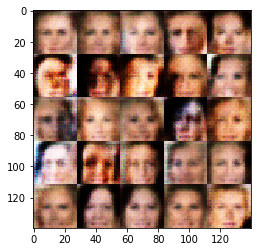

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.4020 Sum Loss: 2.4056
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 3.4021 Sum Loss: 4.4907
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.1973 Sum Loss: 2.0848
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.4582 Sum Loss: 2.5565
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.2195 Sum Loss: 2.7024
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.5118 Sum Loss: 2.4267
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5665 Sum Loss: 1.9625
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.8628 Sum Loss: 2.6491
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9877 Sum Loss: 2.1435
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 2.0795 Sum Loss: 2.8964


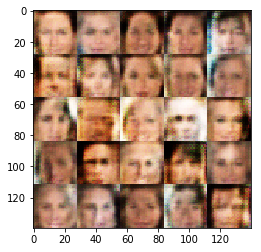

Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.4285 Sum Loss: 2.0623
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.7908 Sum Loss: 2.4952
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 2.5875 Sum Loss: 3.4492
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.4318 Sum Loss: 2.2924
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.1482 Sum Loss: 2.2033
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8331 Sum Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 2.7770 Sum Loss: 3.4659
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.9802 Sum Loss: 3.1317
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.1708 Sum Loss: 2.3185
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.0936 Sum Loss: 2.1404


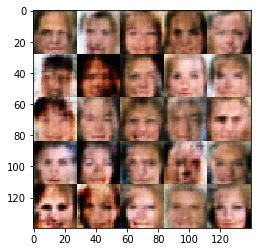

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.8679 Sum Loss: 3.1357
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.1171 Sum Loss: 2.2033
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9386 Sum Loss: 2.1246
Epoch 1/1... Discriminator Loss: 2.1334... Generator Loss: 0.2727 Sum Loss: 2.4061
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4810 Sum Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.6926 Sum Loss: 2.4996
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 2.7006 Sum Loss: 3.8054
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.6641 Sum Loss: 2.6923
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.6499 Sum Loss: 2.6908
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0773 Sum Loss: 2.0697


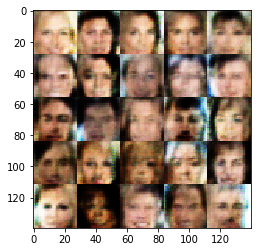

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.3148 Sum Loss: 2.5157
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9715 Sum Loss: 2.2380
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6786 Sum Loss: 2.1248
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.5348 Sum Loss: 2.8652
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.3433 Sum Loss: 2.5618
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 2.0381 Sum Loss: 3.2979
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.7322 Sum Loss: 2.7542
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 2.1168 Sum Loss: 3.0658
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.2498 Sum Loss: 2.1380
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7820 Sum Loss: 2.0479


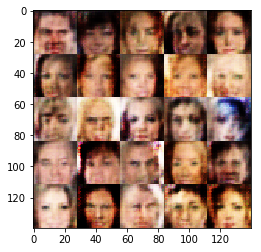

Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7442 Sum Loss: 2.1712
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 2.5101 Sum Loss: 3.8986
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 1.2576 Sum Loss: 2.6485
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.7463 Sum Loss: 2.8239
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 2.4584 Sum Loss: 3.3873
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9619 Sum Loss: 2.0075
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.1532 Sum Loss: 2.1367
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.7810 Sum Loss: 3.0420
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.3871 Sum Loss: 2.1229
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.1571 Sum Loss: 2.2375


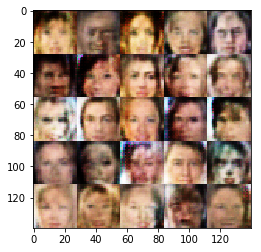

Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.7814 Sum Loss: 2.5036
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.1413 Sum Loss: 2.2203
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.3637 Sum Loss: 2.5620
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 1.1999 Sum Loss: 2.4798
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5715 Sum Loss: 2.0619
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8042 Sum Loss: 2.0141
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.9533 Sum Loss: 2.2313
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.7000 Sum Loss: 2.9153
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0423 Sum Loss: 2.3074
Epoch 1/1... Discriminator Loss: 1.8516... Generator Loss: 0.2819 Sum Loss: 2.1335


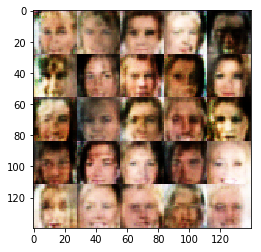

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.0438 Sum Loss: 2.2508
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.2668 Sum Loss: 2.1664
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.0500 Sum Loss: 2.3000
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7503 Sum Loss: 1.8587
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.1900 Sum Loss: 2.3986
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6954 Sum Loss: 1.9594
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.2208 Sum Loss: 2.1483
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.3873 Sum Loss: 1.9601
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.3079 Sum Loss: 2.4032
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.2984 Sum Loss: 2.2822


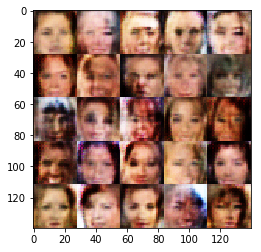

Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5573 Sum Loss: 2.0272
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.3666 Sum Loss: 2.3806
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 2.2767 Sum Loss: 3.3115
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.1597 Sum Loss: 2.0372
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.2350 Sum Loss: 2.3721
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.9997 Sum Loss: 2.0706
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.8255 Sum Loss: 2.0709
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.5879 Sum Loss: 2.1418
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.3935 Sum Loss: 2.6659
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.0087 Sum Loss: 2.2291


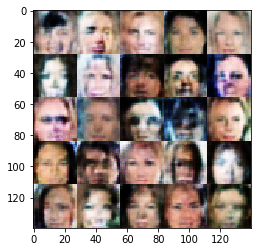

Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.1521 Sum Loss: 2.1995
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.2534 Sum Loss: 2.3761
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.9280 Sum Loss: 2.0113
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5065 Sum Loss: 2.0264
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 2.0155 Sum Loss: 3.0363
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.5213 Sum Loss: 2.5868
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7192 Sum Loss: 1.9737
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8302 Sum Loss: 2.0750
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.4832 Sum Loss: 1.9545
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.5943 Sum Loss: 2.6101


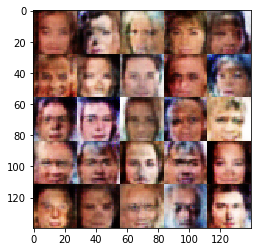

Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.5612 Sum Loss: 2.7553
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.1031 Sum Loss: 2.2793
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.4792 Sum Loss: 2.1678
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8992 Sum Loss: 2.1530
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5359 Sum Loss: 2.0158
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.1500 Sum Loss: 2.4851
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.1251 Sum Loss: 2.2005
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.4241 Sum Loss: 2.4883
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9964 Sum Loss: 2.1322
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.5343 Sum Loss: 1.8988


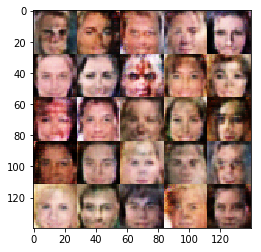

Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9082 Sum Loss: 2.0106
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.1040 Sum Loss: 2.1234
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7754 Sum Loss: 2.1902
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.7020 Sum Loss: 2.6166
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5688 Sum Loss: 2.1151
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8789 Sum Loss: 2.0811
Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 0.2922 Sum Loss: 2.0760
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8065 Sum Loss: 1.8660
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.4701 Sum Loss: 2.5658
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.9234 Sum Loss: 1.9043


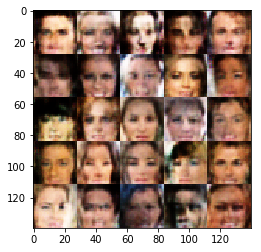

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6049 Sum Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.6757... Generator Loss: 0.3679 Sum Loss: 2.0436
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8484 Sum Loss: 2.1284
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.2884 Sum Loss: 2.3596
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.1951 Sum Loss: 1.9765
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.4197 Sum Loss: 2.0279
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.0889 Sum Loss: 2.2975
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8271 Sum Loss: 2.2535
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.0050 Sum Loss: 2.1481
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.3679 Sum Loss: 2.2343


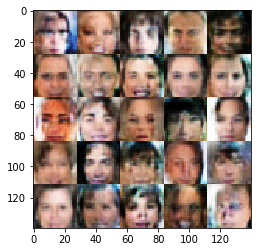

Epoch 1/1... Discriminator Loss: 1.8553... Generator Loss: 0.3498 Sum Loss: 2.2051
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.9106 Sum Loss: 2.6543
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 1.1829 Sum Loss: 2.5160
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5909 Sum Loss: 1.8771
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.7860 Sum Loss: 2.4672
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8893 Sum Loss: 2.0772
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6903 Sum Loss: 2.0001
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 3.2225 Sum Loss: 4.7707
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.3832 Sum Loss: 2.1168
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.2445 Sum Loss: 2.1607


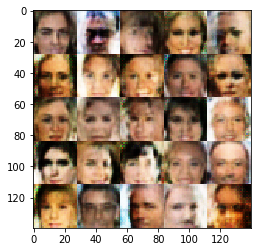

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7895 Sum Loss: 2.1446
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.9110 Sum Loss: 1.9308
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.9986 Sum Loss: 2.2523
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.3930 Sum Loss: 2.7158
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8078 Sum Loss: 1.9945
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 2.5600 Sum Loss: 3.3068
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.5060 Sum Loss: 2.8466
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7430 Sum Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8563 Sum Loss: 2.0769
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.6655 Sum Loss: 2.3653


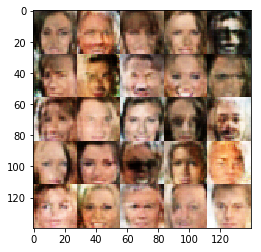

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8710 Sum Loss: 2.1127
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.1990 Sum Loss: 2.1876
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.6261 Sum Loss: 2.5700
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.5658 Sum Loss: 2.4723
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.5806 Sum Loss: 2.4891
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.1626 Sum Loss: 2.3691
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.2741 Sum Loss: 2.3602
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.4793 Sum Loss: 1.9776
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 2.6970 Sum Loss: 3.6530
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 2.9422 Sum Loss: 3.7738


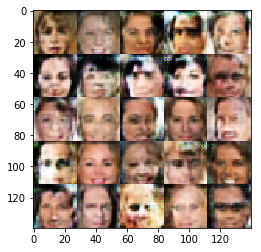

Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.0420 Sum Loss: 2.1349
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7124 Sum Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.3911 Sum Loss: 2.5948
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8974 Sum Loss: 2.1974
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.4949 Sum Loss: 2.4611
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6157 Sum Loss: 2.0366
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8694 Sum Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8728 Sum Loss: 2.0426
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.4833 Sum Loss: 2.6270
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 1.0130 Sum Loss: 2.4187


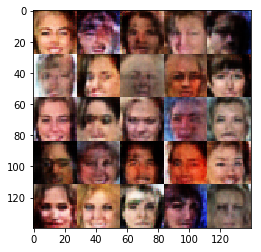

Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.8033 Sum Loss: 1.8969
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6739 Sum Loss: 2.0329
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0834 Sum Loss: 1.9951
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8022 Sum Loss: 1.9949
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6515 Sum Loss: 1.9857
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.4091 Sum Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 2.1073 Sum Loss: 3.0480
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 2.1770 Sum Loss: 3.1792
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6330 Sum Loss: 2.0215
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1000 Sum Loss: 2.1130


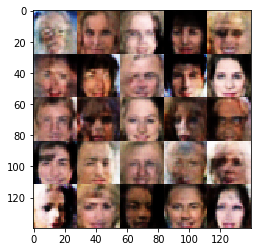

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.5603 Sum Loss: 1.9154
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6639 Sum Loss: 2.0467
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9049 Sum Loss: 2.2480
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8498 Sum Loss: 2.1300
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8975 Sum Loss: 1.9111
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 1.6540 Sum Loss: 2.9746
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.1243 Sum Loss: 2.1893
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.8130 Sum Loss: 2.9335
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.4668 Sum Loss: 2.5830
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6033 Sum Loss: 2.0704


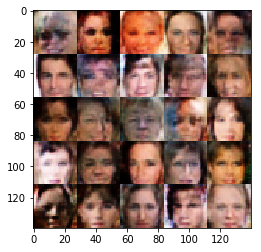

Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.5829 Sum Loss: 2.0918
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.2609 Sum Loss: 2.5049
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.7765 Sum Loss: 1.8890
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 1.7823 Sum Loss: 3.1245
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4309 Sum Loss: 1.8580
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9895 Sum Loss: 2.1406
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5790 Sum Loss: 2.0111
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.9733 Sum Loss: 2.0052
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.3468 Sum Loss: 2.4878
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.1255 Sum Loss: 2.1815


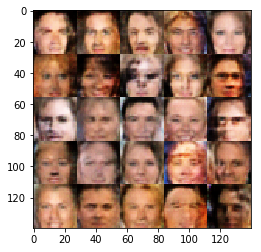

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 1.5383 Sum Loss: 2.8918
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.1172 Sum Loss: 2.2628
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.5536 Sum Loss: 2.1104
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7573 Sum Loss: 2.1970
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.9666 Sum Loss: 3.0738
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6116 Sum Loss: 1.8341
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.7353 Sum Loss: 2.5073
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.1678 Sum Loss: 2.4163
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.0360 Sum Loss: 2.3160
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7324 Sum Loss: 1.9080


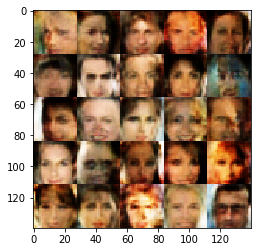

Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.9709 Sum Loss: 2.8727
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.3992 Sum Loss: 2.3963
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.2962 Sum Loss: 2.4431
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.0206 Sum Loss: 2.1629
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9933 Sum Loss: 2.1701
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.3384 Sum Loss: 2.1517
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.9417 Sum Loss: 2.2044
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.5653 Sum Loss: 2.7665
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7186 Sum Loss: 1.9949
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.3042 Sum Loss: 2.8242


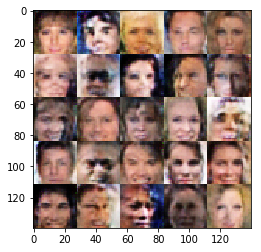

Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8707 Sum Loss: 2.0773
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9848 Sum Loss: 1.9670
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8513 Sum Loss: 1.8994
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7634 Sum Loss: 1.9170
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.6192 Sum Loss: 2.7190
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8932 Sum Loss: 2.2503
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.1906 Sum Loss: 2.3042
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5904 Sum Loss: 2.0067
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.0555 Sum Loss: 2.2794
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0223 Sum Loss: 2.1157


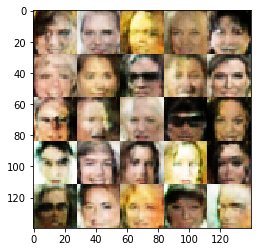

Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.9387 Sum Loss: 2.4760
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.9978 Sum Loss: 2.0406
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.9771 Sum Loss: 2.3216
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7997 Sum Loss: 2.0180
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.8986 Sum Loss: 2.0411
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 1.2584 Sum Loss: 2.7257
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.8664 Sum Loss: 2.7595
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.4576 Sum Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.7534 Sum Loss: 2.3162
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.5336 Sum Loss: 2.7531


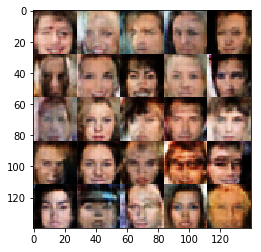

Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9261 Sum Loss: 2.0456
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.3831 Sum Loss: 2.5550
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6565 Sum Loss: 2.0969
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.1264 Sum Loss: 2.1569
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 2.0952 Sum Loss: 3.1197
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8127 Sum Loss: 2.0132
Epoch 1/1... Discriminator Loss: 1.9243... Generator Loss: 0.3387 Sum Loss: 2.2630
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.2576 Sum Loss: 2.2129
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9439 Sum Loss: 2.1771
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.4990 Sum Loss: 2.5118


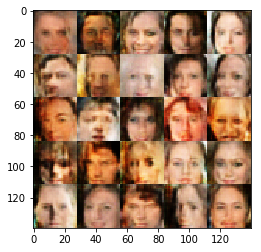

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7069 Sum Loss: 1.9927
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.1561 Sum Loss: 2.1972
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.6981 Sum Loss: 3.0221
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.8802 Sum Loss: 3.1217
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6392 Sum Loss: 1.9705
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6852 Sum Loss: 1.8295
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.4971 Sum Loss: 2.1022
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7417 Sum Loss: 2.1445
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9450 Sum Loss: 1.9778
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 1.5391 Sum Loss: 3.0642


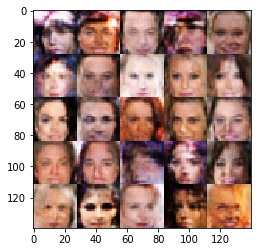

Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8232 Sum Loss: 1.9856
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7067 Sum Loss: 2.1224
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 1.5903 Sum Loss: 3.0409
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6800 Sum Loss: 2.0612
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7643 Sum Loss: 2.2290
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.4165 Sum Loss: 1.9900
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.2469 Sum Loss: 2.2476
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.0578 Sum Loss: 2.3814
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.2461 Sum Loss: 2.3975
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8306 Sum Loss: 2.1315


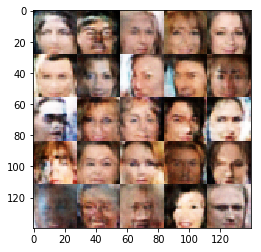

Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.7303 Sum Loss: 1.9420
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8403 Sum Loss: 2.1238
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.1673 Sum Loss: 2.2293
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9114 Sum Loss: 2.1799
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6232 Sum Loss: 2.0745
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.0565 Sum Loss: 2.2252
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.1261 Sum Loss: 2.3653
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.4644 Sum Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 2.9168 Sum Loss: 3.7315
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6793 Sum Loss: 2.0368


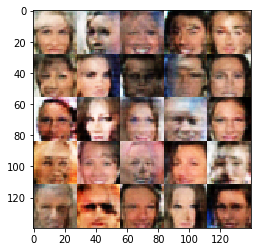

Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.3304 Sum Loss: 2.5228
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.9316 Sum Loss: 2.1279
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7090 Sum Loss: 2.0421
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7887 Sum Loss: 1.8951
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.7372 Sum Loss: 1.8236
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6218 Sum Loss: 1.9034


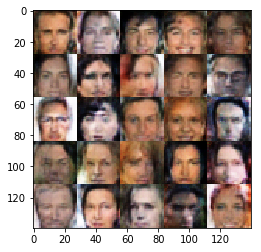

In [119]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.